## Reinforcement Learning for seq2seq

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)

Unlike most deep learning researchers do, we won't only train it to maximize likelihood of correct translation, but also employ reinforcement learning to actually teach it to translate with as few errors as possible.


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                #way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  #maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          #how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) #our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        
        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word,trans = (he,en) if MODE=='he-to-en' else (en,he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue
        
        word_to_translation[word].append(trans)
    
print ("size = ",len(word_to_translation))

size =  130113


In [3]:
#get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [4]:
from sklearn.model_selection import train_test_split
train_words,test_words = train_test_split(all_words,test_size=0.1,random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [5]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0 101  55  92 140   6  77 125   1   1   1   1   1   1]
 [  0 101 121  46   6  77 125 114  24 119 101 138   6   1]
 [  0 101 119 141 115 121   1   1   1   1   1   1   1   1]
 [  0 101 119 141  34  78   1   1   1   1   1   1   1   1]
 [  0 101 140   6 119 138   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

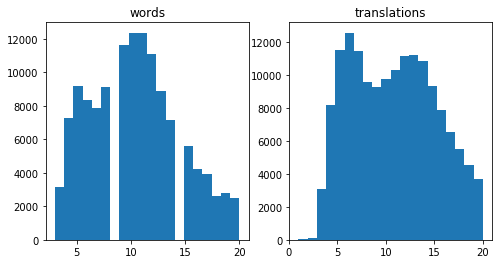

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len,all_words)),bins=20);

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)),bins=20);


### Step 3: deploy encoder-decoder

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.weights`__ - weights from all model layers [a list of variables]

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [8]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

/home/jose/scratch/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
from basic_model_tf import BasicTranslationModel
model = BasicTranslationModel('model',inp_voc,out_voc,
                              emb_size=64, hid_size=128)

s.run(tf.global_variables_initializer())

Using TensorFlow backend.


In [10]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])
out = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])

# translate inp (with untrained model)
sampled_out, logp = out,model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n",out,logp)
print("\nSample translations:\n", s.run(sampled_out))


Symbolic_translate output:
 Tensor("PlaceholderWithDefault_1:0", shape=(?, ?), dtype=int32) (<tf.Tensor 'transpose_1:0' shape=(?, ?) dtype=int32>, <tf.Tensor 'Reshape_1:0' shape=(?, ?, 283) dtype=float32>)

Sample translations:
 [[1 8 1 6 4]
 [3 3 6 4 4]
 [5 5 8 2 7]]


In [11]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp,out)
print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:,:2,:5])


Symbolic_score output:
 Tensor("Reshape_3:0", shape=(?, ?, 283), dtype=float32)

Log-probabilities (clipped):
 [[[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -5.6481504  -5.637344   -5.643134   -5.6368465  -5.642728 ]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -5.643635   -5.636943   -5.649117   -5.6392555  -5.638474 ]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -5.6435037  -5.637863   -5.6464005  -5.643591   -5.6396546]]]


In [13]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None,None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)
    
def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)
    

In [14]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert isinstance(greedy_translations,tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
Dummy translations: ['œľçتいν御žžžž‘@@ぼぼぼáぼáぼぼττττعع', 'œрưưx°̇ɱɱcɱ′いぺぺḳοοpоо御о御οppć', '½تν!)j úоěěěķ!سあ榎(و!°*°ẋ//ц']
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [17]:
import editdistance # !pip install editdistance

def get_distance(word,trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references)!=0,"wrong/unknown word"
    return min(editdistance.eval(trans,ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words,np.ndarray)
    
    batch_words = np.random.choice(words,size=bsize,replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance,batch_words,batch_trans))
    
    return np.array(distances,dtype='float32')

In [18]:
#should be around 5-50 and decrease rapidly after training :)
[score(test_words,10).mean() for _ in range(5)]

[34.5, 24.7, 43.4, 31.4, 39.9]

## Step 2: Supervised pre-training

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [19]:
# import utility functions
from basic_model_tf import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32',[None,None])
    reference_answers = tf.placeholder('int32',[None,None])
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq =  model.symbolic_score(input_sequence, reference_answers)
    
    # compute mean crossentropy
    crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)
    
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    
    loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)
    
    # Build weights optimizer. Use model.weights to get all trainable params.
    train_step = tf.train.AdamOptimizer().minimize(loss, var_list=model.weights)
    
    
# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

Actually run training on minibatches

In [20]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words,size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get,batch_words))
    batch_trans = list(map(random.choice,batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [21]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[  0  73 141  55   6  73   8  41  87 153 135 114  97  20 159 172   1]
 [  0  49 141  92  73 114 115  48 119   1   1   1   1   1   1   1   1]
 [  0  34 119 121  92  78 114  78 101  92 115   6  76   1   1   1   1]]
Target:
[[  0  61 126 231 207 163 138  29 236 261   1   1   1   1   1]
 [  0  18  26  25 139 163 203  25 207 207 276 231 207   1   1]
 [  0 280 231  26 278 207  25 163 138  25 207 268 276 141   1]]


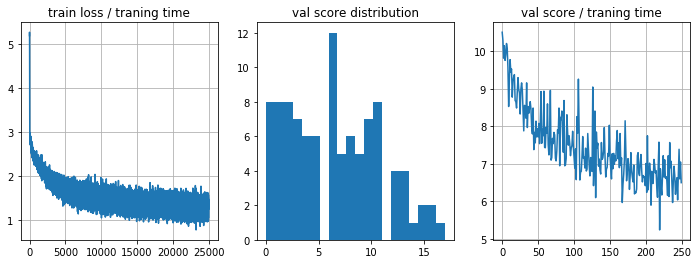

100%|██████████| 25000/25000 [15:11<00:00, 27.42it/s]

llh=1.292, mean score=6.634


In [22]:
from IPython.display import clear_output
from tqdm import tqdm,trange #or use tqdm_notebook,tnrange

loss_history=[]
editdist_history = []

for i in trange(25000):
    bx,by = sample_batch(train_words, word_to_translation, 32)
    
    feed_dict = {
        supervised_training.input_sequence:bx,
        supervised_training.reference_answers:by
    }
    
    loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
        
# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [23]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

כל אנשי סמיילי -> carnes of jamili
קטגוריה:ערוץ 2 -> hagi
עבודה מהבית -> abbation man
פראליה -> paralia
קפלר 42 -> kfara carch
קטגוריה:מתאסלמים -> matalimation
בושמי -> boshmi
לאונרדו -> leonardo
שאמה -> shama
עכברה -> achabra


In [24]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:",np.mean(test_scores))

100%|██████████| 407/407 [00:10<00:00, 37.12it/s]

Supervised test score: 6.653320012296342


## Preparing for reinforcement learning

First we need to define loss function as a custom tf operation.

The simple way to do so is through `tensorflow.py_func` wrapper.
```
def my_func(x):
  # x will be a numpy array with the contents of the placeholder below
  return np.sinh(x)
inp = tf.placeholder(tf.float32)
y = tf.py_func(my_func, [inp], tf.float32)
```


__Your task__ is to implement `_compute_levenshtein` function that takes matrices of words and translations, along with input masks, then converts those to actual words and phonemes and computes min-levenshtein via __get_distance__ function above.


In [31]:
Vocab??

In [45]:
def _compute_levenshtein(words_ix,trans_ix):
    """
    A custom tensorflow operation that computes levenshtein loss for predicted trans.
    
    Params:
    - words_ix - a matrix of letter indices, shape=[batch_size,word_length]
    - words_mask - a matrix of zeros/ones, 
       1 means "word is still not finished"
       0 means "word has already finished and this is padding"
    
    - trans_mask - a matrix of output letter indices, shape=[batch_size,translation_length]
    - trans_mask - a matrix of zeros/ones, similar to words_mask but for trans_ix
    
    
    Please implement the function and make sure it passes tests from the next cell.
    
    """
    
    #convert words to strings
    #words = <restore words (a list of strings) from words_ix. Use vocab>
    words = inp_voc.to_lines(words_ix)

    assert type(words) is list and type(words[0]) is str and len(words)==len(words_ix)
    
    #convert translations to lists
    translations = out_voc.to_lines(trans_ix)
    #translations = <restore trans (a list of lists of phonemes) from trans_ix

    assert type(translations) is list and type(translations[0]) is str and len(translations)==len(trans_ix)

    #computes levenstein distances. can be arbitrary python code.
    distances = [get_distance(i,j) for i,j in zip(words,translations)]
    #distances = <apply get_distance to each pair of [words,translations]>
    
    assert type(distances) in (list,tuple,np.ndarray) and len(distances) == len(words_ix)
    
    distances = np.array(list(distances),dtype='float32')
    return distances

def compute_levenshtein(words_ix,trans_ix):
    out = tf.py_func(_compute_levenshtein,[words_ix,trans_ix,],tf.float32)
    out.set_shape([None])
    
    return tf.stop_gradient(out)

Simple test suite to make sure your implementation is correct. Hint: if you run into any bugs, feel free to use print from inside _compute_levenshtein.

In [46]:
#test suite
#sample random batch of (words, correct trans, wrong trans)
batch_words = np.random.choice(train_words, size=100 )
batch_trans = list(map(random.choice,map(word_to_translation.get,batch_words )))
batch_trans_wrong = np.random.choice(all_translations,size=100)

batch_words_ix = tf.constant(inp_voc.to_matrix(batch_words))
batch_trans_ix = tf.constant(out_voc.to_matrix(batch_trans))
batch_trans_wrong_ix = tf.constant(out_voc.to_matrix(batch_trans_wrong))

In [47]:
#assert compute_levenshtein is zero for ideal translations
correct_answers_score = compute_levenshtein(batch_words_ix ,batch_trans_ix).eval()

assert np.all(correct_answers_score==0),"a perfect translation got nonzero levenshtein score!"

print("Everything seems alright!")

Everything seems alright!


In [48]:
#assert compute_levenshtein matches actual scoring function
wrong_answers_score = compute_levenshtein(batch_words_ix,batch_trans_wrong_ix).eval()

true_wrong_answers_score = np.array(list(map(get_distance,batch_words,batch_trans_wrong)))

assert np.all(wrong_answers_score==true_wrong_answers_score),"for some word symbolic levenshtein is different from actual levenshtein distance"

print("Everything seems alright!")

Everything seems alright!


Once you got it working...


* You may now want to __remove/comment asserts__ from function code for a slight speed-up.

* There's a more detailed tutorial on custom tensorflow ops: [`py_func`](https://www.tensorflow.org/api_docs/python/tf/py_func), [`low-level`](https://www.tensorflow.org/api_docs/python/tf/py_func).

## 3. Self-critical policy gradient

In this section you'll implement algorithm called self-critical sequence training (here's an [article](https://arxiv.org/abs/1612.00563)).

The algorithm is a vanilla policy gradient with a special baseline. 

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$

Here reward R(x,y) is a __negative levenshtein distance__ (since we minimize it). The baseline __b(x)__ represents how well model fares on word __x__.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $.

Luckily, we already obtained the required outputs: `model.greedy_translations, model.greedy_mask` and we only need to compute levenshtein using `compute_levenshtein` function.


In [50]:
??model

In [68]:
class trainer:    
    
    input_sequence = tf.placeholder('int32',[None,None])
    
    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp =  model.symbolic_translate(input_sequence, greedy=False)
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp = model.symbolic_translate(input_sequence, greedy=True)
    
    rewards = - compute_levenshtein(input_sequence, sample_translations)
    
    # compute __negative__ levenshtein for greedy mode
    baseline = - compute_levenshtein(input_sequence,greedy_translations)
    
    # compute advantage using rewards and baseline
    advantage = rewards-baseline
    assert advantage.shape.ndims ==1, "advantage must be of shape [batch_size]"
    
    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logprobs_phoneme = select_values_over_last_axis(sample_logp, sample_translations)
    
    # Compute policy gradient
    # or rather surrogate function who's gradient is policy gradient
    J = logprobs_phoneme*advantage[:,None]
    
    mask = infer_mask(sample_translations,out_voc.eos_ix)
    loss = - tf.reduce_sum(J*mask) / tf.reduce_sum(mask)
    
    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just phoneme_logprobs
    entropy = -tf.reduce_sum(tf.log(sample_logp)*sample_logp,axis=-1)

    
    #<compute entropy matrix of shape [batch,seq_length], H=-sum(p*log_p), don't forget the sign!>
    
    assert entropy.shape.ndims == 2, "please make sure elementwise entropy is of shape [batch,time]"

    loss -= 0.01*tf.reduce_sum(entropy*mask) / tf.reduce_sum(mask)
    
    # compute weight updates, clip by norm
    grads = tf.gradients(loss,model.weights)
    grads = tf.clip_by_global_norm(grads,5)[0]

    train_step = tf.train.AdamOptimizer(learning_rate=1e-5).apply_gradients(zip(grads, model.weights,))
    
    
    
initialize_uninitialized()

# Policy gradient training


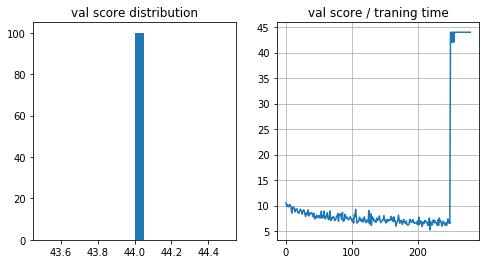

  2%|▏         | 2201/100000 [03:00<2:13:38, 12.20it/s]

J=nan, mean score=44.000


  2%|▏         | 2219/100000 [03:01<2:13:35, 12.20it/s]

KeyboardInterrupt: 

In [69]:
for i in trange(100000):
    bx = sample_batch(train_words,word_to_translation,32)[0]
    pseudo_loss,_ = s.run([trainer.loss, trainer.train_step],{trainer.input_sequence:bx})
    
    loss_history.append(
        pseudo_loss
        )
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(122)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))

In [70]:
model.translate("EXAMPLE;")

AttributeError: 'BasicTranslationModel' object has no attribute 'translate'

### Results

In [71]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

כל אנשי סמיילי -> ________________________________
קטגוריה:ערוץ 2 -> ________________________________
עבודה מהבית -> __________________________
פראליה -> ________________
קפלר 42 -> __________________
קטגוריה:מתאסלמים -> ____________________________________
בושמי -> ______________
לאונרדו -> __________________
שאמה -> ____________
עכברה -> ______________


In [72]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
print("Supervised test score:",np.mean(test_scores))

# ^^ If you get Out Of Memory, please replace this with batched computation


  2%|▏         | 2219/100000 [03:20<2:27:00, 11.09it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jose/scratch/venv/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jose/scratch/venv/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 407/407 [00:12<00:00, 33.90it/s]

Supervised test score: 42.20534890869966


### Grader

In [73]:
assert np.mean(test_scores) < 8
#TODO scitator pls add coursera grader

AssertionError: 

## More

If you finished early and want more adventures for your computation time, __restart with EASY_MODE=False__ and experiment to find a good model/curriculum for that task.

We recommend to start with the following architecture

```
encoder---decoder

           P(y|h)
             ^
 LSTM  ->   LSTM
  ^          ^
 LSTM  ->   LSTM
  ^          ^
input       y_prev
```

__Note:__ you can fit all 4 state tensors of both LSTMs into a in a single state - just assume that it contains, for example, [h0, c0, h1, c1] - pack it in encode and update in decode.


Here are some cool ideas on what you can do then.

__General tips & tricks:__
* In some tensorflow versions and for some layers, it is required that each rnn/gru/lstm cell gets it's own `tf.variable_scope(unique_name, reuse=False)`.
  * Otherwise it will complain about wrong tensor sizes because it tries to reuse weights from one rnn to the other.
* You will likely need to adjust pre-training time for such a network.
* Supervised pre-training may benefit from clipping gradients somehow.
* SCST may indulge a higher learning rate in some cases and changing entropy regularizer over time.
* It's often useful to save pre-trained model parameters to not re-train it every time you want new policy gradient parameters. 
* When leaving training for nighttime, try setting REPORT_FREQ to a larger value (e.g. 500) not to waste time on it.


### Attention
There's more than one way to connect decoder to encoder
  * __Vanilla:__ layer_i of encoder last state goes to layer_i of decoder initial state
  * __Every tick:__ feed encoder last state _on every iteration_ of decoder.
  * __Attention:__ allow decoder to "peek" at one (or several) positions of encoded sequence on every tick.
  
The most effective (and cool) of those is, of course, attention.
You can read more about attention [in this nice blog post](https://distill.pub/2016/augmented-rnns/). The easiest way to begin is to use "soft" attention with "additive" or "dot-product" intermediate layers.

__Tips__
* Model usually generalizes better if you no longer allow decoder to see final encoder state
* Once your model made it through several epochs, it is a good idea to visualize attention maps to understand what your model has actually learned
* If you opted for hard attention, we recommend gumbel-softmax instead of sampling

### UREX
* This is a way to improve exploration in policy-based settings. The main idea is that you find and upweight under-appreciated actions.
* Here's [video](https://www.youtube.com/watch?v=fZNyHoXgV7M&feature=youtu.be&t=3444)
 and an [article](https://arxiv.org/abs/1611.09321).
* You may want to reduce batch size 'cuz UREX requires you to sample multiple times per source sentence.
* Once you got it working, try using experience replay with importance sampling instead of (in addition to) basic UREX.

### Some additional ideas:
* (advanced deep learning) It may be a good idea to first train on small phrases and then adapt to larger ones (a.k.a. training curriculum).
* (advanced nlp) You may want to switch from raw utf8 to something like unicode or even syllables to make task easier.
* (advanced nlp) Since hebrew words are written __with vowels omitted__, you may want to use a small Hebrew vowel markup dataset at `he-pron-wiktionary.txt`.

__Contributions:__ This notebook is brought to you by
* Yandex [MT team](https://tech.yandex.com/translate/)
* Denis Mazur ([DeniskaMazur](https://github.com/DeniskaMazur)), Oleg Vasilev ([Omrigan](https://github.com/Omrigan/)), Dmitry Emelyanenko ([TixFeniks](https://github.com/tixfeniks)) and Fedor Ratnikov ([justheuristic](https://github.com/justheuristic/))
* Dataset is parsed from [Wiktionary](https://en.wiktionary.org), which is under CC-BY-SA and GFDL licenses.
